# Equilibrating the nanotube + methane simulation

The aim of this notebook is to create an equilibrated nanotube simulation. 

We will do this in the following steps:
1. Load the current nanotube + methane simulation from SubtleGame. <= "nanotube_1_original.xml"
2. In VR, place the methane in the approx. desired position. => save as "nanotube_2.xml"
3. Run energy minimisation, perform equilibration for 5 ns, until the energies and temperature are stable. => save as "nanotube_3_equilibrated.xml"

In [1]:
from nanover.omni import OmniRunner
from nanover.omni.openmm import OpenMMSimulation
from nanover.app import NanoverImdClient
from nanover.openmm import serializer
import numpy as np
import openmm.app as app
from openmm import LangevinIntegrator
from simtk import unit

## Step 1: Storing the file names

In [2]:
# 1
input_xml = "nanotube_original.xml"
# 2
nanotube_2_xml = "nanotube_2.xml"
# 3 
nanotube_3_equilibrated = "nanotube_3_equilibrated.xml"
equilibration_statedata_file = "nanotube_equilibration.dcd"
equilibration_dcd_file = "nanotube_equilibration.log"
# 4
equilibration_final_check_dcd_file = "nanotube_equilibration_final_check.dcd"
equilibration_final_check_statedata_file = "nanotube_equilibration_final_check.log"

## Step 2: Moving the methane in VR

In [ ]:
original_simulation = OpenMMSimulation.from_xml_path(input_xml)
imd_runner = OmniRunner.with_basic_server(original_simulation, name="rhos-server")
imd_runner.next()

In [ ]:
# connect a client
client = NanoverImdClient.autoconnect(name="rhos-server")
client.subscribe_to_frames()
client.wait_until_first_frame();

In [ ]:
with open(nanotube_2_xml, 'w') as outfile:
    outfile.write(serializer.serialize_simulation(imd_runner.simulation.simulation))

In [ ]:
client.close()
imd_runner.close()

## Step 3: Equilibration

In [ ]:
# Load the simulation from file
simulation = OpenMMSimulation.from_xml_path(nanotube_2_xml)
simulation.load()

# Create reporters for recording the simulation
dcd_reporter = app.DCDReporter(equilibration_dcd_file, 1)
statedata_reporter = app.StateDataReporter(equilibration_statedata_file, 1, 
                                           temperature=True, step=True,
                                           time=True, potentialEnergy=True, kineticEnergy=True)

# Attach reporters
simulation.simulation.reporters.append(dcd_reporter)
simulation.simulation.reporters.append(statedata_reporter)

In [ ]:
# Set parameters
total_time_in_ps = 5000
time_step_interval_in_ps = 0.002
desired_interval_in_ps = 100

total_num_steps = total_time_in_ps/time_step_interval_in_ps
print(f"Running for {total_num_steps} steps")

# Run the dynamics
cumulative_total_time_ps = 0

for n in range(int(total_time_in_ps/desired_interval_in_ps)):
    
    simulation.simulation.step(desired_interval_in_ps)
    cumulative_total_time_ps += desired_interval_in_ps
    print(f"{cumulative_total_time_ps} ps run.")

    # Save the simulation with the serialized State
    file_name =  f"nanotube_equilibration_{cumulative_total_time_ps}_ps.xml"
    with open(file_name, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

with open(nanotube_3_equilibrated, 'w') as outfile:
    outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

In [ ]:
# Close the reporters
dcd_reporter.__del__()
statedata_reporter.__del__()

## Step 3.5: Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Create data labels
sim_step_label = "Step #"
pot_energy_label = "Potential Energy (kJ/mole)"
temp_label = "Temperature (K)"
sim_step_label = "Step #"
sim_step_axis_label = "Simulation step"

rolling_avg_temperature ="Rolling average temperature"
rolling_stddev_temperature = "Rolling std dev temperature"
rolling_avg_potential_energy ="Rolling average potential energy"
rolling_stddev_potential_energy = "Rolling std dev potential energy"

# Load the log file into a Pandas DataFrame
df = pd.read_csv(equilibration_statedata_file, sep=",")

# Format the column headings and print
df = df.rename(columns={'#"Step"': sim_step_label})

# Compute rolling average
steps = 200
df[rolling_avg_temperature] = df[temp_label].rolling(window=steps, min_periods=1).mean()
df[rolling_stddev_temperature] = df[temp_label].rolling(window=100, min_periods=1).std()

df[rolling_avg_potential_energy] = df[pot_energy_label].rolling(window=steps, min_periods=1).mean()
df[rolling_stddev_potential_energy] = df[pot_energy_label].rolling(window=100, min_periods=1).std()

# print(df)

In [5]:
df[rolling_stddev_potential_energy]

0             NaN
1        7.222033
2       12.268305
3       17.868531
4       23.627618
          ...    
4995    12.849329
4996    13.006501
4997    13.198651
4998    13.386174
4999    13.531227
Name: Rolling std dev potential energy, Length: 5000, dtype: float64

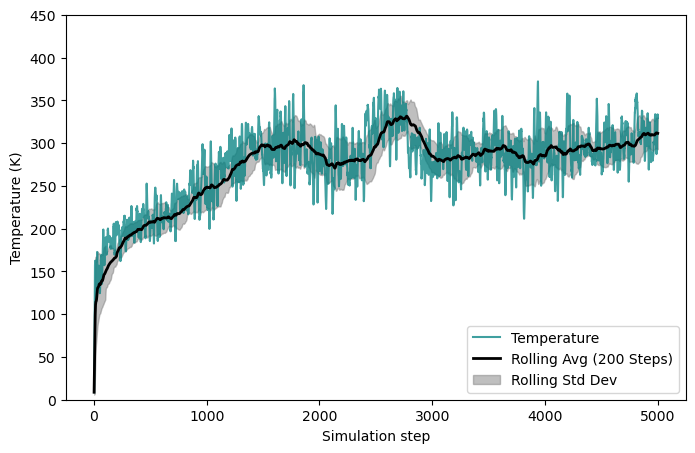

In [6]:
# Plot the temperature
plt.figure(figsize=(8, 5))
plt.plot(df[sim_step_label], df[temp_label], label="Temperature", color="teal", alpha=0.75)

# Plot rolling mean average
plt.plot(df[sim_step_label], df[rolling_avg_temperature], label=f'Rolling Avg ({steps} Steps)', color="black", linewidth=2)

# Plot rolling standard deviation as a shaded region
plt.fill_between(df[sim_step_label], 
                 df[rolling_avg_temperature] - df[rolling_stddev_temperature], 
                 df[rolling_avg_temperature] + df[rolling_stddev_temperature], 
                 color='gray', alpha=0.5, label="Rolling Std Dev")

# Formatting plot
plt.xlabel(sim_step_axis_label)
plt.ylabel(temp_label)
plt.ylim(0,450)
plt.legend()

# Show/save
# plt.show()
plt.savefig("nanotube_equilibration_temperature-against-time.png")

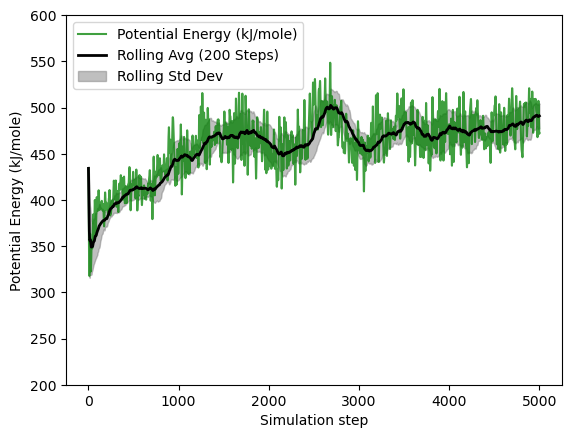

In [7]:
# Plot the potential energy
plt.plot(df[sim_step_label], df[pot_energy_label], label=pot_energy_label, color= 'green', alpha=0.75)

# Plot the rolling mean average
plt.plot(df[sim_step_label], df[rolling_avg_potential_energy], label=f'Rolling Avg ({steps} Steps)', color="black", linewidth=2)

# Plot rolling standard deviation as a shaded region
plt.fill_between(df[sim_step_label], 
                 df[rolling_avg_potential_energy] - df[rolling_stddev_potential_energy], 
                 df[rolling_avg_potential_energy] + df[rolling_stddev_potential_energy], 
                 color='gray', alpha=0.5, label="Rolling Std Dev")

# Formatting plot
plt.xlabel(sim_step_axis_label)
plt.ylabel(pot_energy_label)
plt.ylim(200, 600)
plt.legend()

# Show/save
# plt.show()
plt.savefig("nanotube_equilibration_potential-energy-against-time.png")

## Step 4: Final check of equilibration

In [ ]:
# Load the simulation from file
simulation = OpenMMSimulation.from_xml_path(nanotube_3_equilibrated)
simulation.load()

# Create reporters for recording the simulation
dcd_reporter = app.DCDReporter(equilibration_final_check_dcd_file, 1)
statedata_reporter = app.StateDataReporter(equilibration_final_check_statedata_file, 1, 
                                           temperature=True, step=True,
                                           time=True, potentialEnergy=True, kineticEnergy=True)

# Attach reporters
simulation.simulation.reporters.append(dcd_reporter)
simulation.simulation.reporters.append(statedata_reporter)

In [ ]:
# Set parameters
total_time_in_ps = 1500
time_step_interval_in_ps = 0.002
desired_interval_in_ps = 100

total_num_steps = total_time_in_ps/time_step_interval_in_ps
print(f"Running for {total_num_steps} steps")

# Run the dynamics
cumulative_total_time_ps = 0

for n in range(int(total_time_in_ps/desired_interval_in_ps)):
    
    simulation.simulation.step(desired_interval_in_ps)
    cumulative_total_time_ps += desired_interval_in_ps
    print(f"{cumulative_total_time_ps} ps run.")

    # Save the simulation with the serialized State
    file_name =  f"nanotube_equilibration_final_check_{cumulative_total_time_ps}_ps.xml"
    with open(file_name, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

In [ ]:
# Close the reporters
dcd_reporter.__del__()
statedata_reporter.__del__()

## Step 4.5: Analysis

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# Create data labels
sim_step_label = "Step #"
pot_energy_label = "Potential Energy (kJ/mole)"
temp_label = "Temperature (K)"
sim_step_label = "Step #"
sim_step_axis_label = "Simulation step"

rolling_avg_temperature ="Rolling average temperature"
rolling_stddev_temperature = "Rolling std dev temperature"
rolling_avg_potential_energy ="Rolling average potential energy"
rolling_stddev_potential_energy = "Rolling std dev potential energy"

# Load the log file into a Pandas DataFrame
df = pd.read_csv(equilibration_final_check_statedata_file, sep=",")

# Format the column headings and print
df = df.rename(columns={'#"Step"': sim_step_label})

# Compute rolling average
steps = 200
df[rolling_avg_temperature] = df[temp_label].rolling(window=steps, min_periods=1).mean()
df[rolling_stddev_temperature] = df[temp_label].rolling(window=100, min_periods=1).std()

df[rolling_avg_potential_energy] = df[pot_energy_label].rolling(window=steps, min_periods=1).mean()
df[rolling_stddev_potential_energy] = df[pot_energy_label].rolling(window=100, min_periods=1).std()


In [11]:
df[rolling_stddev_potential_energy]

0             NaN
1        2.474008
2        3.705366
3        4.952162
4        6.114970
          ...    
1495    14.456534
1496    14.805301
1497    15.216725
1498    15.665148
1499    16.126128
Name: Rolling std dev potential energy, Length: 1500, dtype: float64

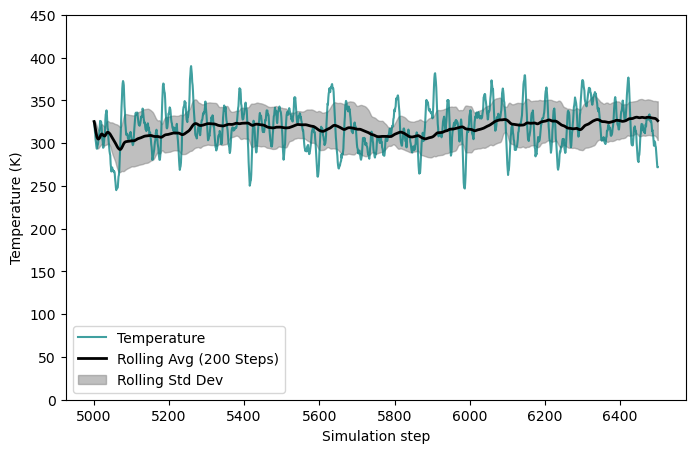

In [12]:
# Plot the temperature
plt.figure(figsize=(8, 5))
plt.plot(df[sim_step_label], df[temp_label], label="Temperature", color="teal", alpha=0.75)

# Plot rolling mean average
plt.plot(df[sim_step_label], df[rolling_avg_temperature], label=f'Rolling Avg ({steps} Steps)', color="black", linewidth=2)

# Plot rolling standard deviation as a shaded region
plt.fill_between(df[sim_step_label], 
                 df[rolling_avg_temperature] - df[rolling_stddev_temperature], 
                 df[rolling_avg_temperature] + df[rolling_stddev_temperature], 
                 color='gray', alpha=0.5, label="Rolling Std Dev")

# Formatting plot
plt.xlabel(sim_step_axis_label)
plt.ylabel(temp_label)
plt.ylim(0,450)
plt.legend()

# Show/save
# plt.show()
plt.savefig("nanotube_final-check-of-equilibration_temperature-against-time.png")

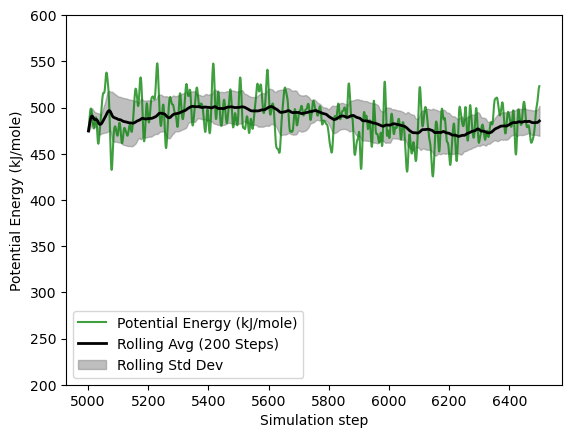

In [13]:
# Plot the potential energy
plt.plot(df[sim_step_label], df[pot_energy_label], label=pot_energy_label, color= 'green', alpha=0.75)

# Plot the rolling mean average
plt.plot(df[sim_step_label], df[rolling_avg_potential_energy], label=f'Rolling Avg ({steps} Steps)', color="black", linewidth=2)

# Plot rolling standard deviation as a shaded region
plt.fill_between(df[sim_step_label], 
                 df[rolling_avg_potential_energy] - df[rolling_stddev_potential_energy], 
                 df[rolling_avg_potential_energy] + df[rolling_stddev_potential_energy], 
                 color='gray', alpha=0.5, label="Rolling Std Dev")

# Formatting plot
plt.xlabel(sim_step_axis_label)
plt.ylabel(pot_energy_label)
plt.ylim(200, 600)
plt.legend()

# Show/save
# plt.show()
plt.savefig("nanotube_final-check-of-equilibration_potential-energy-against-time.png")